In [89]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D, Activation
from tqdm import tqdm
from collections import Counter
from eunjeon import Mecab
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [62]:
상폐기업뉴스 = pd.read_csv('../../뉴스전처리/상폐기업뉴스전처리.csv')
상폐기업뉴스추가 = pd.read_csv('../../뉴스전처리/상폐기업뉴스전처리추가.csv')
stopwords = pd.read_csv('../stopword.csv')

뉴스 = pd.concat([상폐기업뉴스, 상폐기업뉴스추가])
뉴스

,기업,기사발행일,기사제목,뉴스기사본문전처리
0,네이쳐글로벌,2010.08.16. 오후 5:21,"네이쳐글로벌, 반기검토의견 ""의견거절'…거래정지",네이쳐글로벌는 일 반기 검토 의견이 의견거절로 관리종목 지정 사유가 발생했다고 공시...
1,네이쳐글로벌,2010.07.15. 오후 6:46,네이쳐글로벌 신용등급 `CC`로 두단계 하향,네이쳐글로벌의 신용등급을 기존 에서 으로 하향 조정한다고 한신정평가가 일 밝혔다....
2,네이쳐글로벌,2010.06.03. 오후 5:06,"네이쳐글로벌, 20대 1 감자 실시",네이쳐글로벌은 대 감자를 결의했다고 일 공시했다.감자 주주총회일은 다음달 일 감...
3,네이쳐글로벌,2010.05.24. 오전 10:41,<생생코스닥> 네이쳐글로벌 3거래일 연속 하한가,네이쳐글로벌이 연 거래일 연속 하한가를 기록하며 주가가 원 선 마저 위협 받고 있다...
4,네이쳐글로벌,2010.05.18. 오후 1:23,"네이쳐글로벌 ""생수시장 진출 하반기 150억 계획""",네이쳐글로벌은 대규모 생수회사를 자산양수도 방식으로 인수 추진 중이라고 일 밝혔다....
...,...,...,...,...
5787,코썬바이오,2020.01.10. 오후 7:40,"코썬바이오, 불성실공시법인 지정",한국거래소 코스닥시장본부는 일 코썬바이오가 지난해 월 최대주주 변경을 수반하는 주...
5788,코썬바이오,2019.12.20. 오후 6:53,"거래소, 코썬바이오 불성실 공시법인 지정…23일 주식거래 정지",한국거래소 코스닥시장본부는 오는 일 코썬바이오를 불성실 공시 법인으로 지정한다고 ...
5789,코썬바이오,2019.12.23. 오후 5:17,코썬바이오 불성실 공시법인 지정예고,코썬바이오는 공시불이행으로 불성실 공시법인으로 지정예고 됐다고 일 공시했다.사유는 ...
5790,코썬바이오,2019.12.23. 오후 5:23,"거래소, 코썬바이오 불성실 공시법인 지정예고",한국거래소 코스닥시장본부는 코썬바이오가 공시불이행에 따라 불성실 공시법인으로 지정...


In [63]:
mecab = Mecab()
# Mecab으로 토큰화
뉴스['뉴스기사본문전처리'] = 뉴스['뉴스기사본문전처리'].apply(lambda x: mecab.morphs(x))
# 한 글자 단어 제거
뉴스['뉴스기사본문전처리'] = 뉴스['뉴스기사본문전처리'].apply(lambda x: [word for word in x if len(word) > 1])
# stopwords에 있는 불용어 제거
뉴스['뉴스기사본문전처리'] = 뉴스['뉴스기사본문전처리'].apply(lambda x: [word for word in x if word not in stopwords])
뉴스.reset_index(inplace=True)
뉴스

,index,기업,기사발행일,기사제목,뉴스기사본문전처리
0,0,네이쳐글로벌,2010.08.16. 오후 5:21,"네이쳐글로벌, 반기검토의견 ""의견거절'…거래정지","[글로벌, 반기, 검토, 의견, 의견, 거절, 관리, 종목, 지정, 사유, 발생, ..."
1,1,네이쳐글로벌,2010.07.15. 오후 6:46,네이쳐글로벌 신용등급 `CC`로 두단계 하향,"[글로벌, 신용, 등급, 기존, 에서, 으로, 하향, 조정, 한다고, 신정, 평가,..."
2,2,네이쳐글로벌,2010.06.03. 오후 5:06,"네이쳐글로벌, 20대 1 감자 실시","[글로벌, 감자, 결의, 다고, 공시, 감자, 주주, 총회, 다음, 감자, 기준일,..."
3,3,네이쳐글로벌,2010.05.24. 오전 10:41,<생생코스닥> 네이쳐글로벌 3거래일 연속 하한가,"[글로벌, 거래일, 연속, 하한가, 기록, 주가, 마저, 위협, 글로벌, 오전, 시..."
4,4,네이쳐글로벌,2010.05.18. 오후 1:23,"네이쳐글로벌 ""생수시장 진출 하반기 150억 계획""","[글로벌, 규모, 생수, 회사, 자산, 양수, 방식, 으로, 인수, 추진, 라고, ..."
...,...,...,...,...,...
8489,5787,코썬바이오,2020.01.10. 오후 7:40,"코썬바이오, 불성실공시법인 지정","[한국, 거래소, 코스닥, 시장, 본부, 바이오, 지난해, 최대, 주주, 변경, 수..."
8490,5788,코썬바이오,2019.12.20. 오후 6:53,"거래소, 코썬바이오 불성실 공시법인 지정…23일 주식거래 정지","[한국, 거래소, 코스닥, 시장, 본부, 바이오, 성실, 공시, 법인, 으로, 지정..."
8491,5789,코썬바이오,2019.12.23. 오후 5:17,코썬바이오 불성실 공시법인 지정예고,"[공시, 불이행, 으로, 성실, 공시, 법인, 으로, 지정, 예고, 다고, 공시, ..."
8492,5790,코썬바이오,2019.12.23. 오후 5:23,"거래소, 코썬바이오 불성실 공시법인 지정예고","[한국, 거래소, 코스닥, 시장, 본부, 바이오, 공시, 불이행, 따라, 성실, 공..."


기사의 최대 길이 : 2959
기사의 평균 길이 : 181.98316458676712


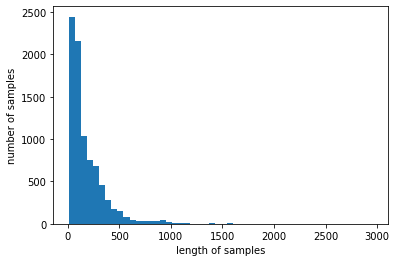

In [64]:
print('기사의 최대 길이 :',max(len(review) for review in 뉴스['뉴스기사본문전처리']))
print('기사의 평균 길이 :',sum(map(len, 뉴스['뉴스기사본문전처리']))/len(뉴스['뉴스기사본문전처리']))
plt.hist([len(review) for review in 뉴스['뉴스기사본문전처리']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [65]:
분류단어 = ['폐지', '퇴출', '기로', '벼랑']
분류단어 = '|'.join(분류단어)
분류단어

'폐지|퇴출|기로|벼랑'

In [66]:
뉴스[뉴스['뉴스기사본문전처리'].str.contains('글로벌', na=False, case=False)]
라벨 = 뉴스['뉴스기사본문전처리'].apply(lambda x: [word for word in x if word in 분류단어])
라벨 = 라벨.apply(lambda x: 1 if (len(x)>=1) else 0)
뉴스['긍정부정기사분류'] = 라벨
뉴스.drop('index', axis=1, inplace=True)
뉴스

,기업,기사발행일,기사제목,뉴스기사본문전처리,긍정부정기사분류
0,네이쳐글로벌,2010.08.16. 오후 5:21,"네이쳐글로벌, 반기검토의견 ""의견거절'…거래정지","[글로벌, 반기, 검토, 의견, 의견, 거절, 관리, 종목, 지정, 사유, 발생, ...",0
1,네이쳐글로벌,2010.07.15. 오후 6:46,네이쳐글로벌 신용등급 `CC`로 두단계 하향,"[글로벌, 신용, 등급, 기존, 에서, 으로, 하향, 조정, 한다고, 신정, 평가,...",0
2,네이쳐글로벌,2010.06.03. 오후 5:06,"네이쳐글로벌, 20대 1 감자 실시","[글로벌, 감자, 결의, 다고, 공시, 감자, 주주, 총회, 다음, 감자, 기준일,...",0
3,네이쳐글로벌,2010.05.24. 오전 10:41,<생생코스닥> 네이쳐글로벌 3거래일 연속 하한가,"[글로벌, 거래일, 연속, 하한가, 기록, 주가, 마저, 위협, 글로벌, 오전, 시...",0
4,네이쳐글로벌,2010.05.18. 오후 1:23,"네이쳐글로벌 ""생수시장 진출 하반기 150억 계획""","[글로벌, 규모, 생수, 회사, 자산, 양수, 방식, 으로, 인수, 추진, 라고, ...",0
...,...,...,...,...,...
8489,코썬바이오,2020.01.10. 오후 7:40,"코썬바이오, 불성실공시법인 지정","[한국, 거래소, 코스닥, 시장, 본부, 바이오, 지난해, 최대, 주주, 변경, 수...",0
8490,코썬바이오,2019.12.20. 오후 6:53,"거래소, 코썬바이오 불성실 공시법인 지정…23일 주식거래 정지","[한국, 거래소, 코스닥, 시장, 본부, 바이오, 성실, 공시, 법인, 으로, 지정...",0
8491,코썬바이오,2019.12.23. 오후 5:17,코썬바이오 불성실 공시법인 지정예고,"[공시, 불이행, 으로, 성실, 공시, 법인, 으로, 지정, 예고, 다고, 공시, ...",0
8492,코썬바이오,2019.12.23. 오후 5:23,"거래소, 코썬바이오 불성실 공시법인 지정예고","[한국, 거래소, 코스닥, 시장, 본부, 바이오, 공시, 불이행, 따라, 성실, 공...",0


In [67]:
remove_one_word = [x for x in 뉴스['뉴스기사본문전처리'] if len(x) > 1]
remove_one_word = list(itertools.chain(*remove_one_word))
remove_one_word

frequent = Counter(remove_one_word).most_common()

minimum_words = []
for item, count in frequent:
    if count <=10:
        minimum_words.append(item)
minimum_words = '|'.join(minimum_words)

뉴스['뉴스기사본문전처리'] = 뉴스['뉴스기사본문전처리'].apply(lambda x: [word for word in x if word not in minimum_words])

기사의 최대 길이 : 962
기사의 평균 길이 : 62.1105486225571


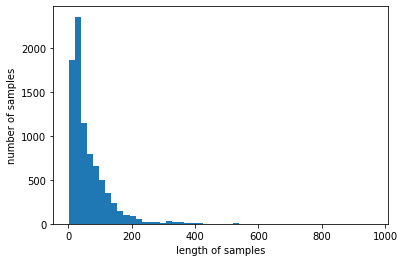

In [68]:
print('기사의 최대 길이 :',max(len(review) for review in 뉴스['뉴스기사본문전처리']))
print('기사의 평균 길이 :',sum(map(len, 뉴스['뉴스기사본문전처리']))/len(뉴스['뉴스기사본문전처리']))
plt.hist([len(review) for review in 뉴스['뉴스기사본문전처리']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [70]:
tokenizer = Tokenizer ()
tokenizer.fit_on_texts(뉴스['뉴스기사본문전처리'])

In [71]:
x_train, x_test, y_train, y_test = train_test_split(뉴스['뉴스기사본문전처리'], 뉴스['긍정부정기사분류'], random_state=42, test_size=0.2)
max_review_length = 100

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print("Shape of train data:", x_train.shape)
print("Shape of Test data:", x_test.shape)

Shape of train data: (6795, 100)
Shape of Test data: (1699, 100)


In [74]:
import tensorflow as tf

def metric_precision(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 precision=TP/(TP+FP)
 return precision

def metric_recall(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 recall=TP/(TP+FN)
 return recall

#F1-score    
def metric_F1score(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 precision=TP/(TP+FP)
 recall=TP/(TP+FN)
 F1score=2*precision*recall/(precision+recall)
 return F1score

In [82]:
# 모델의 설정
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32, input_length=max_review_length))
model.add(Dropout(0.5))
# strides : 컨볼루션 커널 이동 간격 / 보폭
model.add(Conv1D(64, 5, padding='valid', activation="relu", strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
# 새로운 방식
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(optimizer='adam',
	 loss='binary_crossentropy',
	 metrics=['accuracy',
	 		metric_precision,
	 		metric_recall,
	 		metric_F1score,
			 ])
        
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 32)           320000    
                                                                 
 dropout_5 (Dropout)         (None, 100, 32)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 96, 64)            10304     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 dense_5 (Dense)             (None, 24, 1)             65        
                                                                 
 activation_5 (Activation)   (None, 24, 1)             0         
                                                      

In [83]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

print('\n Test F1 Score : %.4f' % (model.evaluate(x_test, y_test)[4]))


Epoch 1: val_loss improved from inf to 0.36775, saving model to ./model\01-0.367755.hdf5

Epoch 2: val_loss improved from 0.36775 to 0.35765, saving model to ./model\02-0.357645.hdf5

Epoch 3: val_loss did not improve from 0.35765

Epoch 4: val_loss did not improve from 0.35765

Epoch 5: val_loss did not improve from 0.35765

Epoch 6: val_loss did not improve from 0.35765

Epoch 7: val_loss did not improve from 0.35765

Epoch 8: val_loss did not improve from 0.35765

Epoch 9: val_loss did not improve from 0.35765

Epoch 10: val_loss did not improve from 0.35765
54/54 [==============================] - 0s 3ms/step - loss: 0.3700 - accuracy: 0.8614 - metric_precision: 0.6400 - metric_recall: nan - metric_F1score: nan

 Test F1 Score : nan


In [78]:
history.

In [60]:
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

In [ ]:
embedding = tf.keras.layers.Embedding(input_dim=10000, output_dim=32, , input_length=max_review_length, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 6, 8], [1, 5, 4, 7], [1, 7, 3, 2, 8]] 에 Embedding 레이어를 적용
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
# get_encoded_sentences는 코드내에서 문장들을 index로 바꿔주기 위해 선언한 함수 

output = embedding(raw_inputs)
print(output)